# Scratch notebook for experimenting with ridge trace algorithm

## Basic plan

0. We use a map of surface brightness, which we will call $B$
1. We start at some point on the emission arc that we want to trace. For instance, the local maximum brightness
2. Find the two perpendicular directions of the principal curvature: $\hat{n}_1$, $\hat{n}_2$
3. Take a step parallel to $\hat{n}_2$, which should be tangential to the arc
4. Then look along the direction $\hat{n}_1$ to find the point of maximum $B$ and set this as the next point on the arc
5. Return to step 2 and repeat
6. We need some criterion for saying when we should stop

In [1]:
import sys
from pathlib import Path
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("talk")
from ridge_trace.curvature import ImageCurvature
from ridge_trace import trace

In [2]:
sys.version_info

sys.version_info(major=3, minor=12, micro=1, releaselevel='final', serial=0)

## Load the image data from FITS files

In [3]:
datapath = Path.cwd().parent / "data"
fitsfiles = list(datapath.glob("*.fits"))
proplyd = "069-601"
hdu = fits.open(fitsfiles[1])["SCI"]

Calculate curvatures as in demo01 notebook

In [4]:
x1, x2 = 250, 420
y1, y2 = 250, 420
v0, d0 = 1.0, 20
ic = ImageCurvature(
    hdu.data, 
    smooth=2.5, 
    sharp=40, 
    max_cutoff=8.5, 
    bbox=[x1, y1, x2, y2], 
    scales=(v0, d0),
)

## Look at traces through the image from the peak


In [5]:
indices = trace.peak_indices(-ic.kappa1)

In [6]:
indices, ic.kappa1[indices], ic.theta2[indices]

((114, 93), -8.541056619175908, 168.65927441248357)

Take the straight line in the direction of max curvature, and also the opposite direction.

In [7]:
y0, x0 = indices
line = trace.StraightLine(x0, y0, ic.theta2[indices])
line2 = trace.StraightLine(x0, y0, ic.theta2[indices] + 180)
line

StraightLine(x0=93, y0=114, theta=168.65927441248357)

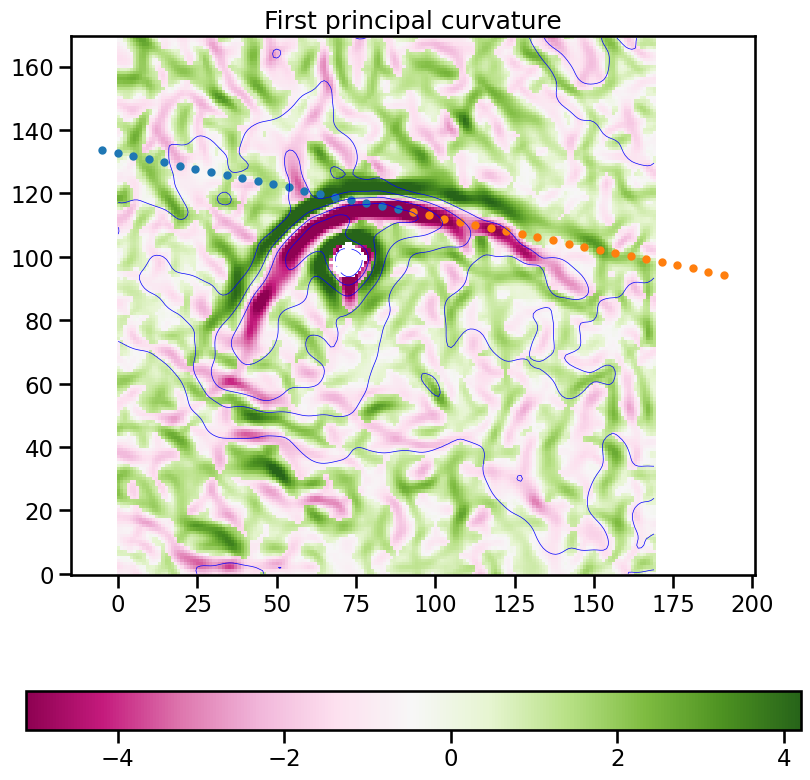

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
m = np.isfinite(ic.kappa1)
kappa_cmap = 'PiYG'
vmin, vmax = np.percentile(ic.kappa1[m], [1, 99])
im1 = ax.imshow(ic.kappa1, origin='lower', vmin=vmin, vmax=vmax, cmap=kappa_cmap)
fig.colorbar(im1, ax=ax, orientation="horizontal")
levels = 0.0 + np.arange(7) * 0.15
ax.contour(ic.image, levels=levels, colors="blue", linewidths=0.5)
ax.scatter(line.points.x[::5], line.points.y[::5], marker=".", color='C0')
ax.scatter(line2.points.x[::5], line2.points.y[::5], marker=".", color='C1')
ax.set_title("First principal curvature")
...;

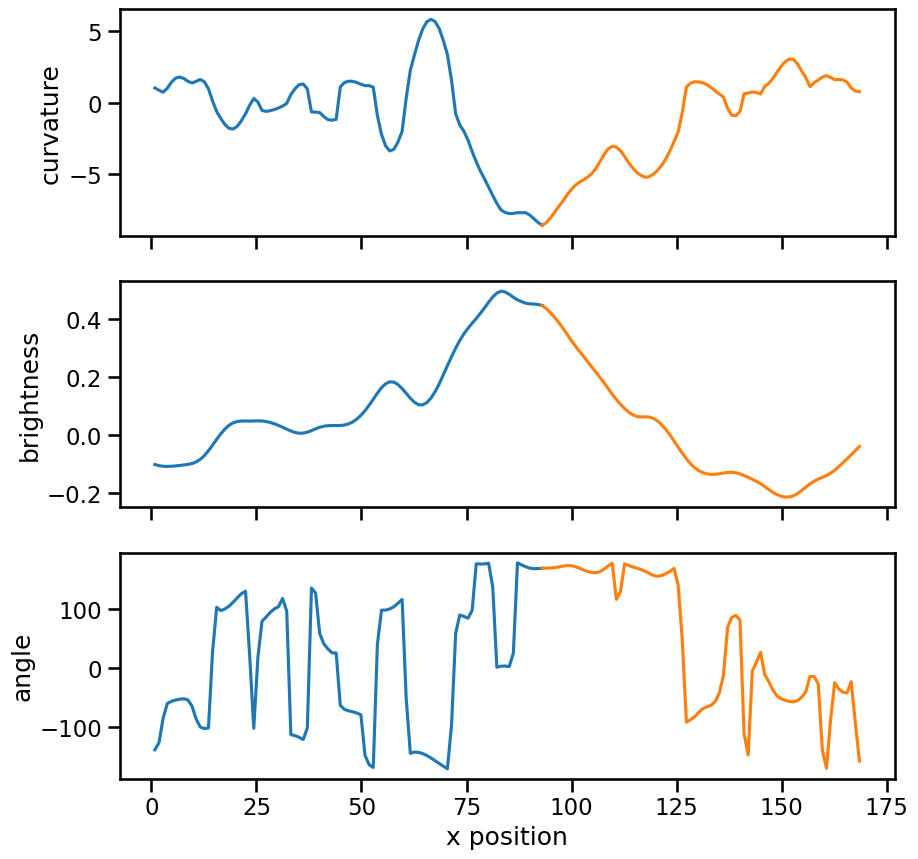

In [12]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axes[0].plot(line.points.x, line.image_values(ic.kappa1))
axes[0].plot(line2.points.x, line2.image_values(ic.kappa1))
axes[1].plot(line.points.x, line.image_values(ic.image))
axes[1].plot(line2.points.x, line2.image_values(ic.image))
axes[2].plot(line.points.x, line.image_values(ic.theta2))
axes[2].plot(line2.points.x, line2.image_values(ic.theta2))
axes[0].set(ylabel="curvature")
axes[1].set(ylabel="brightness")
axes[2].set(xlabel="x position", ylabel="angle")

...;

In [ ]:
trace = [Point(x0, y0)]

## Try to implement algorithm 

We are going to need a function to interpolate from the grid to an arbitrary point